In [2]:
### read in necessary packages
from astropy.io import fits
from astropy.modeling import models, fitting
from astropy import units as u

from specutils.spectra import Spectrum1D, SpectralRegion
from specutils.fitting import fit_generic_continuum
from specutils.fitting import fit_lines

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

from scipy.optimize import curve_fit

In [3]:
### read in sdss data

# sdss catalog with redshifts
sdss_hdu = fits.open('/home/jordan/Documents/MOSDEF_research/data/sdss_dr7_linemeas_latest.fits')
sdss_cat = sdss_hdu[1].data
sdss_col = sdss_hdu[1].columns


# spiral galaxy spectrum
spiral_hdu = fits.open('/home/jordan/Documents/github/sdss_spectra/spiral_galaxies/spec-0270-51909-0481.fits')
spiral_spec = spiral_hdu[1].data 
spiral_col = spiral_hdu[1].columns
spiral_head = spiral_hdu[0].header
# The naming convention for the spectra is spec-plateID-MJD-fiberID.fits

In [4]:
### get the rest wavelength

lam = 10**(spiral_spec["loglam"])

# get the redshift from the large data table (i.e., sdss_dr7_linemeas_latest.fits)
spiral_z = np.array([0.0])
for i in range(len(sdss_cat)):
    if sdss_cat["PLATEID"][i] == spiral_hdu[0].header["PLATEID"] and sdss_cat["MJD"][i] == spiral_hdu[0].header["MJD"] and sdss_cat["FIBERID"][i] == spiral_hdu[0].header["FIBERID"]:
        spiral_z = sdss_cat["Z"][i]

rest_lam = lam/(1+spiral_z)

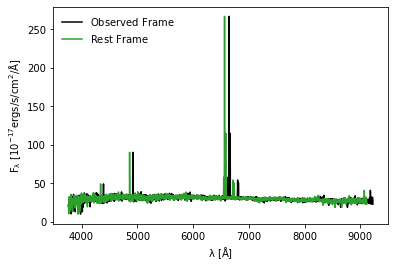

In [5]:
### test shifting spectrum to rest frame

plt.step(lam, spiral_spec["flux"], color='k', label=r'$\rm Observed \ Frame$')
plt.step(rest_lam, spiral_spec["flux"], color='tab:green', label=r'$\rm Rest \ Frame$')
plt.xlabel(r'$\rm \lambda \ [\AA]$')
plt.ylabel(r'$\rm F_{\lambda} \ [10^{-17} ergs/s/cm^{2}/\AA]$')
plt.legend(loc="upper left", frameon=False)
plt.show()

In [6]:
### set up the fit

# give flux, wavelength units
rest_lam_units = rest_lam * u.AA
spiral_spec_units = spiral_spec["flux"] * u.erg / u.s / u.cm**2 / u.AA

# fit the spectrum
spectrum = Spectrum1D(spectral_axis=rest_lam_units, flux=spiral_spec_units)

# fit the continuum
continuum_fit = fit_generic_continuum(spectrum)
continuum_fit_flux = continuum_fit(rest_lam_units)

# subtract the continuum from spectrum and fit the continuum
spectrum_cont_sub = Spectrum1D(spectral_axis=rest_lam_units, flux=spiral_spec_units-continuum_fit_flux)
subtracted_continuum_flux = np.array(spiral_spec_units-continuum_fit_flux)

# find the Ha peak
ha_range_flux = []
for k in range(len(rest_lam)):
    if 6561. <= rest_lam[k] <= 6565:
        ha_range_flux.append(subtracted_continuum_flux[k])
ha_range_flux = np.array(ha_range_flux)
ha_peak_flux = np.max(ha_range_flux)
print("Ha peak flux = ", ha_peak_flux)

# ignore the below warning
# fit_generic_continuum() uses astropy.modeling.fitting.LevMarLSQFitter for fitting
# the warning is suggesting that a linear fitter would be better
# but as you can see below the fit to the continuum works fine
# so there is no need to write a custom function to avoid getting this warning message
# using a simpler fitter would speed up the run time but this is negligible for this simple of a script

Ha peak flux =  234.8331723203994


In [7]:
### fit a Gaussian to the continuum subtracted Ha line

gaus_init = models.Gaussian1D(amplitude=ha_peak_flux*u.erg/u.s/u.cm**2/u.AA, mean=6563.*u.AA, stddev=1.*u.AA)
gaus_fit = fit_lines(spectrum_cont_sub, gaus_init)
gaus_fit_flux = gaus_fit(rest_lam_units)
print("Gaussian Fit: ", gaus_fit)

Gaussian Fit:  Model: Gaussian1D
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Parameters:
          amplitude               mean             stddev      
    erg / (Angstrom cm2 s)      Angstrom          Angstrom     
    ---------------------- ----------------- ------------------
        236.06983196147888 6564.650726722467 1.7072834982764773


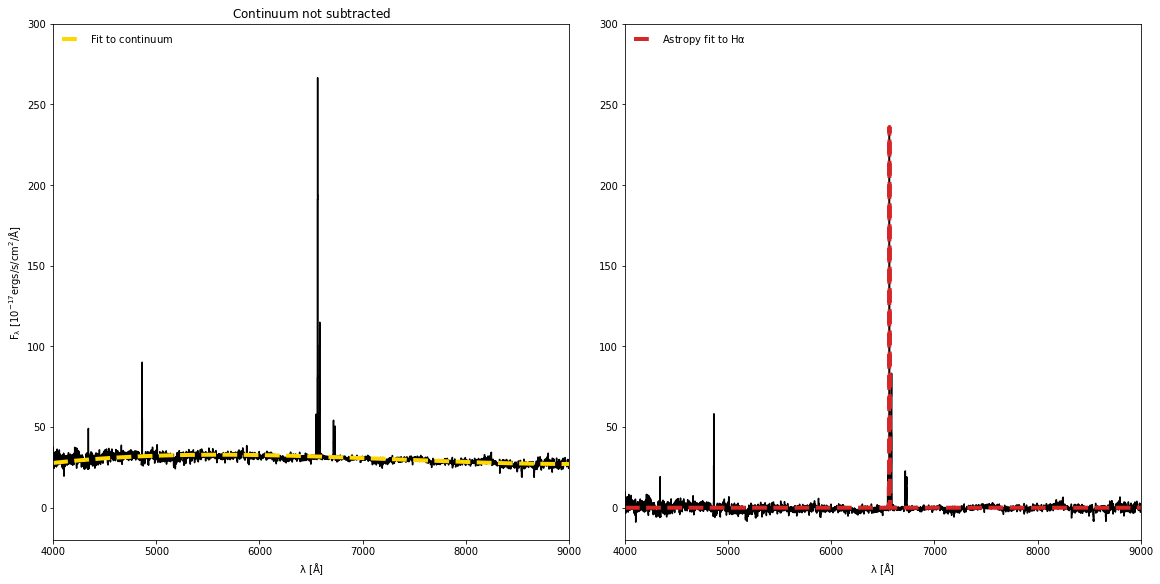

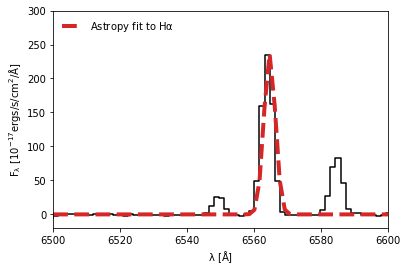

In [8]:
### plot the fits

fig = plt.figure(figsize=(16, 8), constrained_layout=True)
subfig = gridspec.GridSpec(ncols=2, nrows=1, figure=fig)

f_ax1 = fig.add_subplot(subfig[0, 0])
plt.step(rest_lam, spiral_spec["flux"], c="k")
plt.plot(rest_lam, continuum_fit_flux, c="gold", linestyle="--", linewidth=4, label=r'$\rm Fit \ to \ continuum$')
plt.xlabel(r'$\rm \lambda \ [\AA]$')
plt.ylabel(r'$\rm F_{\lambda} \ [10^{-17} ergs/s/cm^{2}/\AA]$')
plt.title(r'$\rm Continuum \ not \ subtracted$')
plt.axis([4000, 9000, -20, 300])
plt.legend(loc="upper left", frameon=False)

f_ax2 = fig.add_subplot(subfig[0, 1])
plt.step(rest_lam, spiral_spec_units-continuum_fit_flux, c="k")
plt.plot(rest_lam, gaus_fit_flux, c="tab:red", linestyle="--", linewidth=4, label=r'$\rm Astropy \ fit \ to \ H\alpha$')
plt.xlabel(r'$\rm \lambda \ [\AA]$')
plt.axis([4000, 9000, -20, 300])
plt.legend(loc="upper left", frameon=False)
plt.show()

plt.step(rest_lam, spiral_spec_units-continuum_fit_flux, c="k")
plt.plot(rest_lam, gaus_fit_flux, c="tab:red", linestyle="--", linewidth=4, label=r'$\rm Astropy \ fit \ to \ H\alpha$')
plt.xlabel(r'$\rm \lambda \ [\AA]$')
plt.ylabel(r'$\rm F_{\lambda} \ [10^{-17} ergs/s/cm^{2}/\AA]$')
plt.axis([6500, 6600, -20, 300])
plt.legend(loc="upper left", frameon=False)
plt.show()


In [9]:
### estimate the signal-to-noise

noise_flux = []
for j in range(len(rest_lam)):
    if 5200. <= rest_lam[j] <= 6200.:
        noise_flux.append(float(subtracted_continuum_flux[j]))
    elif 7000. <= rest_lam[j] <= 8000.:
        noise_flux.append(float(subtracted_continuum_flux[j]))
noise_flux = np.array(noise_flux)
#noise_flux_var = np.var(noise_flux)
noise_flux_std = np.std(noise_flux)*np.sqrt(6.*gaus_fit.stddev.value)

# get S/N
spiral_snr = np.sum(np.array(gaus_fit_flux))/noise_flux_std
print("S/N = ",spiral_snr)

S/N =  141.5616178472146


In [10]:
### fit the Ha line using SciPy

# define the Gaussian function
def gaussian(x, A, mu, sigma):
    g = A*np.exp(-((x-mu)**2/(2*sigma)**2))
    return g

In [11]:
### Fit the Gaussian with Scipy
pvar, coeff = curve_fit(gaussian, rest_lam, subtracted_continuum_flux, p0 = [ha_peak_flux, 6563, 1], maxfev=5000)

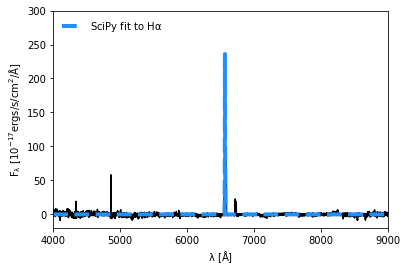

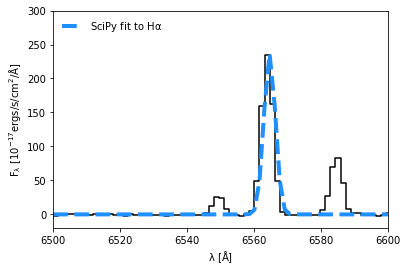

In [12]:
### plot the SciPy fit

#fig = plt.figure(figsize=(16, 8), constrained_layout=True)
#subfig = gridspec.GridSpec(ncols=2, nrows=1, figure=fig)

#f_ax1 = fig.add_subplot(subfig[0, 0])
plt.step(rest_lam, spiral_spec_units-continuum_fit_flux, c="k")
plt.plot(rest_lam, gaussian(rest_lam, *pvar), color="dodgerblue", linestyle="--", linewidth=4, label=r'$\rm SciPy \ fit \ to \ H\alpha$')
plt.xlabel(r'$\rm \lambda \ [\AA]$')
plt.ylabel(r'$\rm F_{\lambda} \ [10^{-17} ergs/s/cm^{2}/\AA]$')
plt.axis([4000, 9000, -20, 300])
plt.legend(loc="upper left", frameon=False)
plt.show()

#f_ax2 = fig.add_subplot(subfig[0, 1])
plt.step(rest_lam, spiral_spec_units-continuum_fit_flux, c="k")
plt.plot(rest_lam, gaussian(rest_lam, *pvar), color="dodgerblue", linestyle="--", linewidth=4, label=r'$\rm SciPy \ fit \ to \ H\alpha$')
plt.xlabel(r'$\rm \lambda \ [\AA]$')
plt.ylabel(r'$\rm F_{\lambda} \ [10^{-17} ergs/s/cm^{2}/\AA]$')
plt.axis([6500, 6600, -20, 300])
plt.legend(loc="upper left", frameon=False)
plt.show()


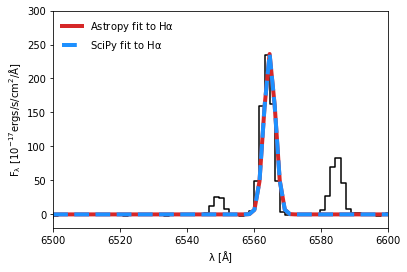

In [13]:
### Compare the SciPy and Astropy fits
plt.step(rest_lam, spiral_spec_units-continuum_fit_flux, c="k")
plt.plot(rest_lam, gaus_fit_flux, c="tab:red", linewidth=4, label=r'$\rm Astropy \ fit \ to \ H\alpha$')
plt.plot(rest_lam, gaussian(rest_lam, *pvar), color="dodgerblue", linestyle="--", linewidth=4, label=r'$\rm SciPy \ fit \ to \ H\alpha$')
plt.xlabel(r'$\rm \lambda \ [\AA]$')
plt.ylabel(r'$\rm F_{\lambda} \ [10^{-17} ergs/s/cm^{2}/\AA]$')
plt.axis([6500, 6600, -20, 300])
plt.legend(loc="upper left", frameon=False)
plt.show()
